Number of data: 2598 
Number of variables: 2
 Working on: Fold=    0.0000, Sigma=    0.0010, Cost=100000.0000
 Working on: Fold=    0.0000, Sigma=    0.0010, Cost=278255.9402
 Working on: Fold=    0.0000, Sigma=    0.0010, Cost=774263.6827
 Working on: Fold=    0.0000, Sigma=    0.0010, Cost=2154434.6900
 Working on: Fold=    0.0000, Sigma=    0.0010, Cost=5994842.5032
 Working on: Fold=    0.0000, Sigma=    0.0010, Cost=16681005.3720
 Working on: Fold=    0.0000, Sigma=    0.0010, Cost=46415888.3361
 Working on: Fold=    0.0000, Sigma=    0.0010, Cost=129154966.5015
 Working on: Fold=    0.0000, Sigma=    0.0010, Cost=359381366.3805
 Working on: Fold=    0.0000, Sigma=    0.0010, Cost=1000000000.0000
 Working on: Fold=    0.0000, Sigma=    0.0028, Cost=100000.0000
 Working on: Fold=    0.0000, Sigma=    0.0028, Cost=278255.9402
 Working on: Fold=    0.0000, Sigma=    0.0028, Cost=774263.6827
 Working on: Fold=    0.0000, Sigma=    0.0028, Cost=2154434.6900
 Working on: Fold=    0.0000

C:\Python27\lib\site-packages\matplotlib\figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


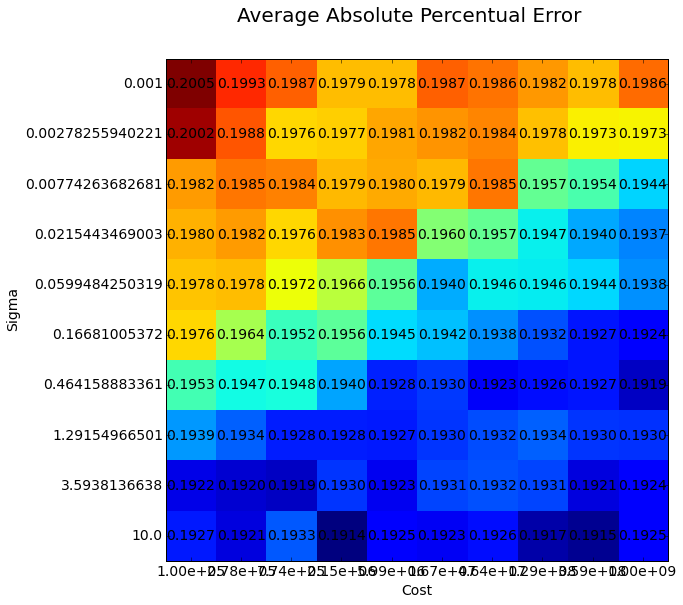

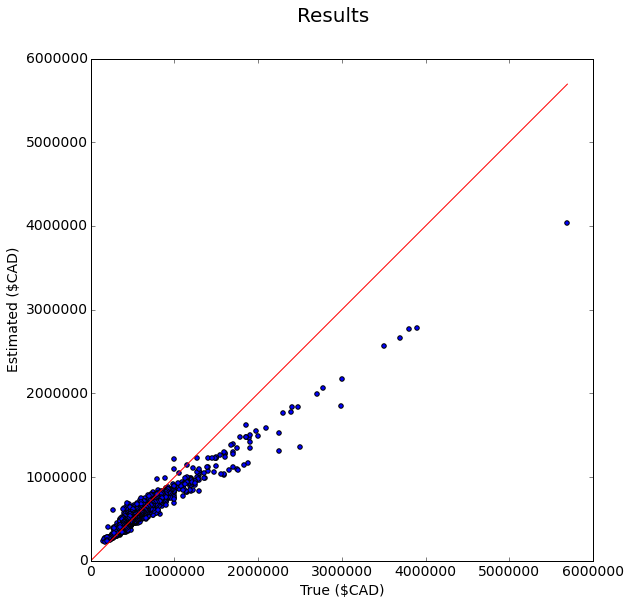

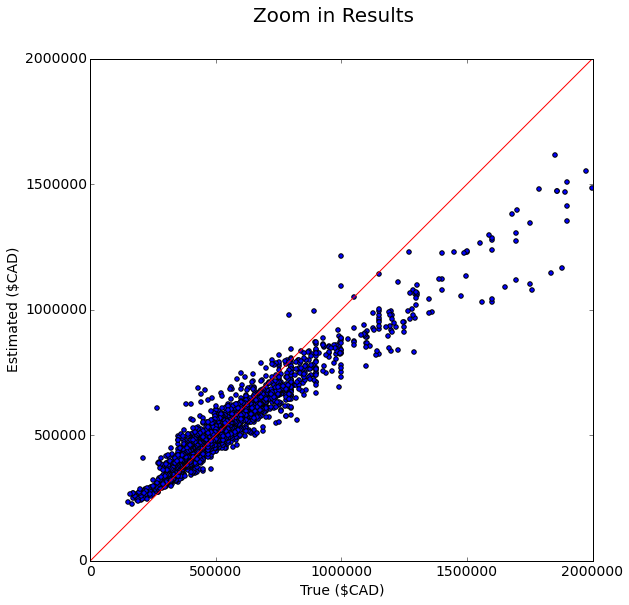

In [1]:
# Perform batch aggregating of three algorithms: SVR, kNN and Decision Tree
# Based on codes of Diogo Silva, Camila Ferreira and Weijie Sun

# This file performs bagging using only geolocations of properties 
# on the dataset containing only values and features of townhouses in Edmonton

# Author: Oleg Oleynikov
# for CMPUT 551
# License: BSD 3 clause

#
# Import needed packages
#
import numpy as np
import time
import pandas as pd
import csv
from numpy import genfromtxt

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge

from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import PolynomialFeatures
#
# Read data
#
dataset = genfromtxt('../../data/realestate/realestate_residential.csv', delimiter=',')
dataset = dataset[1:,:]

ndata=dataset.shape[0]
nvar=dataset.shape[1]

X = dataset[:,1:3]
y = dataset[:,nvar-1]
nvar = X.shape[1]

print('Number of data: %d \nNumber of variables: %d' % (ndata,nvar) )

# BEGIN STUFF FOR SVR
#
# normalize the data attributes
#
min_X = np.amin(X,axis=0)
max_X = np.amax(X,axis=0)
diff_X = max_X-min_X;
nrm_X = np.zeros((ndata,nvar))
for i in range(ndata):
    nrm_X[i,:] = (X[i,:]-min_X) / diff_X
#
# define parameters for cross-validation
#


svr_kbest = SelectKBest(f_regression, k=7)
#nrm_X_svr = svr_kbest.fit_transform(nrm_X, y)
#retained2 = svr_kbest.get_support()
poly = PolynomialFeatures(2)
#nrm_X_svr = poly.fit_transform(nrm_X_svr)



nfold=5

minsigma=-3
maxsigma=1
nsigma=10

mincost=5
maxcost=9
ncost=10

cvsigma=np.logspace(minsigma, maxsigma, nsigma)
cvcost=np.logspace(mincost,maxcost,ncost)
# END STUFF FOR SVR

# BEGIN STUFF FOR KNN
knn_kbest = SelectKBest(f_regression, k=30)
#X_knn = knn_kbest.fit_transform(X,y)
n_neighbors = 20
knn = KNeighborsRegressor(n_neighbors, p = 1, weights='distance')
# END STUFF FOR KNN

# BEGIN STUFF FOR DECISION TREE
dt_kbest = SelectKBest(f_regression, k=7)
#X_dt = dt_kbest.fit_transform(X,y)
#X_dt = poly.fit_transform(X_dt)
dt = DecisionTreeRegressor(max_depth=12)
# END STUFF FOR DECISION TREE

#
# 5-fold cross-validation to define parameters
#
i=0
kf = KFold(ndata, n_folds=nfold, shuffle=True)
cvape=np.zeros((nsigma,ncost,nfold))
for train, test in kf:
    y_train=y[train]
    y_test=y[test]
    
    X_train_svr=nrm_X[train]
    X_test_svr=nrm_X[test]
    
    X_train_knn = X[train]
    X_test_knn = X[test]
    
    X_train_dt = X[train]
    X_test_dt = X[test]
    
    for j in range(nsigma):
        for k in range(ncost):
            print (" Working on: Fold=%10.4f, Sigma=%10.4f, Cost=%10.4f" % (i,cvsigma[j],cvcost[k]) )
            # fit SVR
            svr_rbf=SVR(kernel='rbf', C=cvcost[k], gamma=cvsigma[j])
            y_pred_svr=svr_rbf.fit(X_train_svr, y_train).predict(X_test_svr)
            
            # fit kNN
            y_pred_knn = knn.fit(X_train_knn, y_train).predict(X_test_knn)
            
            # fit decision tree
            y_pred_dt = dt.fit(X_train_dt, y_train).predict(X_test_dt)
            
            # average predictions (aka do bagging)
            y_pred = np.mean([y_pred_svr, y_pred_knn, y_pred_dt], axis=0)
            
            cvape[j,k,i] = np.mean ( np.abs((y_test - y_pred)/y_test) )
    i = i+1           

#
# Mean absolute percentage error
#
cvmape=np.mean(cvape,axis=2)

#
# Get indexes of parameter combination with minimum error
#
idxsigma, idxcost = np.unravel_index(cvmape.argmin(), cvmape.shape)

#
# Print out Results
#
optsigma=cvsigma[idxsigma];
optcost=cvcost[idxcost];
print("Best parameters: \n  Sigma = %10.4f\n  Cost = %10.4f\n  Relative Accuracy = %10.4f" % (cvsigma[idxsigma],cvcost[idxcost],cvmape[idxsigma,idxcost]))

#
# Plot results for all combinations tested
#
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,figsize=(9,9))
ax.imshow(cvmape,interpolation='nearest')
for i in range(nsigma):
    for j in range(ncost):
        ax.text(i,j,("%.4f" % cvmape[j,i]), va='center', ha='center')
        
fig.suptitle('Average Absolute Percentual Error', fontsize=20)
plt.xlabel('Cost')
plt.ylabel('Sigma')

plt.xticks(range(ncost),np.char.mod('%.2e', cvcost))
plt.yticks(range(nsigma),cvsigma)

fig.show()

#
# Run in all data set with optimal parameters
#
svr_rbf=SVR(kernel='rbf', C=optcost, gamma=optsigma)
y_pred_svr=svr_rbf.fit(nrm_X, y).predict(nrm_X)
y_pred_knn = knn.fit(X, y).predict(X)
y_pred_dt = dt.fit(X, y).predict(X)
y_pred = np.mean([y_pred_svr, y_pred_knn, y_pred_dt], axis=0)
trainmape = np.mean ( np.abs((y - y_pred)/y) )

#
# Report Results
#
print("Cross-Validation Accuracy: %10.4f\nTrain set Accuracy:        %10.4f" %(cvmape[idxsigma,idxcost],trainmape))

#
#
#
fig, ax = plt.subplots(1,figsize=(9,9))
ax.scatter(y,y_pred)
ax.plot([0, np.max(y)], [0, np.max(y)], color=[1,0,0])
axy=ax.get_ylim()
axx=ax.get_xlim()
plt.xlim(0,np.max([axx[1],axy[1]]))
plt.ylim(0,np.max([axx[1],axy[1]]))
fig.suptitle('Results', fontsize=20)
plt.xlabel('True ($CAD)')
plt.ylabel('Estimated ($CAD)')

fig, ax = plt.subplots(1,figsize=(9,9))
ax.scatter(y,y_pred)
ax.plot([0, np.max(y)], [0, np.max(y)], color=[1,0,0])
axy=ax.get_ylim()
axx=ax.get_xlim()
plt.xlim(0,2000000)
plt.ylim(0,2000000)
fig.suptitle('Zoom in Results', fontsize=20)
plt.xlabel('True ($CAD)')
plt.ylabel('Estimated ($CAD)')